# DFL - Decision-Focused Learning for VRPs
## Using SPO+ with heuristic solver

In [1]:
# load the autoreload extension
%load_ext autoreload
# set the level of reloading
%autoreload 2

In [2]:
from util import *
import torch
from heuristic.heuristic_solver import HeuristicSolver
from spo import *


In [3]:
# data = [parse_datafile(f'../data/cvrp_1000_100_4_8/instance_{i}') for i in range(15)]
# data = [parse_datafile(f'../data/cvrp_1000_100_4_8/instance_{i}') for i in range(100)]
# data = [parse_datafile(f'../data/cvrp_1000_10_5_8/instance_{i}') for i in range(1000)]
data = [parse_datafile(f'../data/cvrp_1000_25_4_8_0.1/instance_{i}') for i in range(1000)]

Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_0...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_1...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_2...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_3...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_4...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_5...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_6...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_7...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_8...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_9...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_10...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_11...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_12...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_13...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_14...
Parsing datafile: ../data/cvrp_1000_25_4_8_0.1/instance_15...
Parsing datafile: 

In [4]:
from tqdm import tqdm

# solve the VRPs with the actual edge costs and save the solutions
for vrp in tqdm(data):
    solver = HeuristicSolver(vrp)
    # solver = GurobiSolver(vrp)
    solver.solve()
    vrp.actual_solution = solver.get_decision_variables()
    vrp.actual_obj = solver.get_actual_objective()

100%|██████████| 1000/1000 [01:42<00:00,  9.75it/s]


In [5]:
e = torch.tensor([edge.features for edge in data[0].edges], dtype=torch.float32)
e.shape

torch.Size([600, 4])

In [6]:
TRAIN_PERCENTAGE = 0.75
VALIDATION_PERCENTAGE = 0.05
TEST_PERCENTAGE = 0.2

num_train = int(len(data) * TRAIN_PERCENTAGE)
num_val = int(len(data) * VALIDATION_PERCENTAGE)
num_test = int(len(data) * TEST_PERCENTAGE)

vrps_train = data[:num_train]
vrps_val = data[num_train:num_train + num_val]
vrps_test = data[num_train + num_val:]
print(f'Number of training instances: {len(vrps_train)}')
print(f'Number of validation instances: {len(vrps_val)}')
print(f'Number of test instances: {len(vrps_test)}')

Number of training instances: 750
Number of validation instances: 50
Number of test instances: 200


In [20]:
tete = vrps_train

from gnn import GNN
from nce import NCE

num_nodes = len(vrps_train[0].nodes)
num_edges = len(vrps_train[0].edges)
num_feat = len(vrps_train[0].edges[0].features)
cost_model = CostPredictor(num_edges * num_feat, num_edges)
# cost_model = GNN(num_feat, vrps_train[0].edges)

optimizer = torch.optim.Adam(cost_model.parameters(), lr=1e-3, weight_decay=1e-5)
# construct dict from vrp to true solution
true_sols = {vrp: [vrp.actual_solution] for vrp in vrps_train}
nce = NCE(true_sols)
num_epochs = 50
for epoch in range(num_epochs):
    mean_loss = 0
    for idx, vrp in enumerate(tete):
        optimizer.zero_grad()
        # get the edge features and indices
        edge_features = torch.tensor([edge.features for edge in vrp.edges])
        predicted_edge_costs = cost_model(edge_features)
        # set the predicted edge costs
        for i, edge in enumerate(vrp.edges):
            edge.predicted_cost = predicted_edge_costs[i]
        # calculate the loss
        solver = HeuristicSolver(vrp, mode=SolverMode.PRED_COST, max_runtime=0.1)
        # solver = GurobiSolver(vrp, mode=SolverMode.SPO)
        solver.solve()
        # add to pool
        nce.pool[vrp].append(solver.get_decision_variables())

        # call nce
        true_costs = torch.tensor([edge.cost for edge in vrp.edges])
        loss = nce(predicted_edge_costs, true_costs, vrp.actual_solution, vrp)

        # backpropagation
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        print(f'Epoch {epoch + 1} / {num_epochs}, instance {idx + 1} / {len(vrps_train)}, loss: {loss.item()}')
    mean_loss /= len(tete)
    print(
        f'Epoch {epoch + 1} / {num_epochs} done, mean loss: {mean_loss}')
        # f', val loss: {validation_loss(cost_model, vrps_val, spo_plus, HeuristicSolver)}')
    if (epoch + 1) % 5 == 0:
        test(cost_model, vrps_test, HeuristicSolver, is_two_stage=False)

Epoch 1 / 50, instance 1 / 750, loss: 508878.3745408517
Epoch 1 / 50, instance 2 / 750, loss: 85969.96307496296
Epoch 1 / 50, instance 3 / 750, loss: 150393.59914600913
Epoch 1 / 50, instance 4 / 750, loss: 324025.25037225534
Epoch 1 / 50, instance 5 / 750, loss: 4203540.450535804
Epoch 1 / 50, instance 6 / 750, loss: 879732.6584277924
Epoch 1 / 50, instance 7 / 750, loss: 2199015.5902417256
Epoch 1 / 50, instance 8 / 750, loss: 945635.3597127849
Epoch 1 / 50, instance 9 / 750, loss: 949487.7750883879
Epoch 1 / 50, instance 10 / 750, loss: 496287.9926110744
Epoch 1 / 50, instance 11 / 750, loss: 978515.487304374
Epoch 1 / 50, instance 12 / 750, loss: 1279742.7766487477
Epoch 1 / 50, instance 13 / 750, loss: 1609277.0397207595
Epoch 1 / 50, instance 14 / 750, loss: 466346.2144998188
Epoch 1 / 50, instance 15 / 750, loss: 302172.6822262127
Epoch 1 / 50, instance 16 / 750, loss: 873182.0467981335
Epoch 1 / 50, instance 17 / 750, loss: 598564.9232923397
Epoch 1 / 50, instance 18 / 750, los

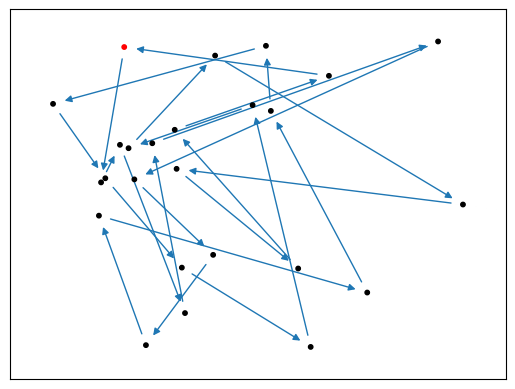

6662.387812525685

In [21]:
# testing
# vrp = vrps_train[10]
vrp = vrps_test[10]

solver = GurobiSolver(vrp)
solver.solve()
draw_solution(solver)
solver.get_actual_objective()

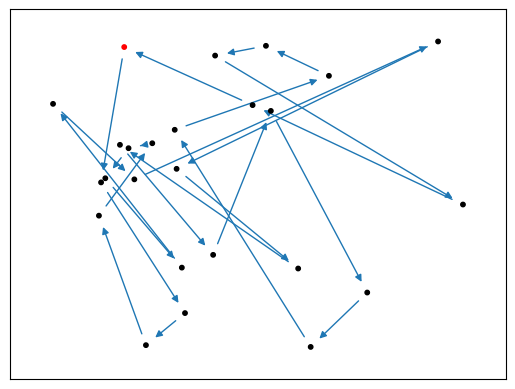

14510.279489599705

In [22]:
solver = HeuristicSolver(vrp)
solver.solve()
draw_solution(solver)
solver.get_actual_objective()

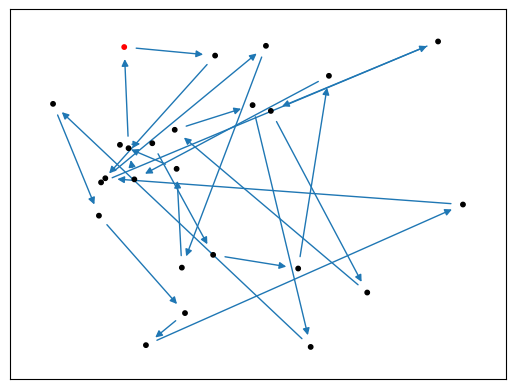

444157.8699015443

In [23]:
predicted_edge_costs = cost_model(torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32))
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = predicted_edge_costs[i]
solver = HeuristicSolver(vrp, mode=SolverMode.PRED_COST, max_runtime=0.1)
# solver = GurobiSolver(vrp, mode=SolverMode.PRED_COST)
solver.solve()
draw_solution(solver)
solver.get_actual_objective()

In [39]:
test(cost_model, vrps_test, HeuristicSolver, is_two_stage=False)

Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8000, accuracy: 0.11538461538461539, actual cost: 7306.7432228994285, predicted cost: 320148.7127380732
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8001, accuracy: 0.2692307692307693, actual cost: 16136.09677594293, predicted cost: 391780.2917179697
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8002, accuracy: 0.46153846153846156, actual cost: 30919.974397909027, predicted cost: 550997.03307088
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8003, accuracy: 0.6538461538461539, actual cost: 40088.672716763074, predicted cost: 818684.0875854477
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8004, accuracy: 0.8076923076923077, actual cost: 52608.648512449996, predicted cost: 1161951.3381517637
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8005, accuracy: 1.0, actual cost: 66473.64691306005, predicted cost: 14